In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Histopathology data/converted.zip" "converted.zip"

In [ ]:
!unzip -q converted.zip

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('converted/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, test_files, train_classes, test_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['ADI' 'BACK' 'DEB' 'LYM' 'MUC' 'MUS' 'NORM' 'STR' 'TUM']


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 1000
batch_size_test = 100

# define how image transformed (image augmentations)
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('converted/', train_files, train_classes, 
                         transforms=image_transform)
test_dataset = Hist('converted/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: ADI


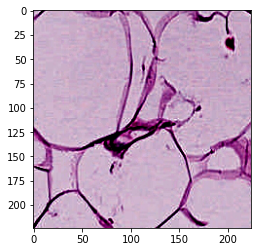

In [ ]:
# import library
import matplotlib.pyplot as plt
# Checking the data loader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# showing random image from dataloader
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Here I have used Alexnet architecture pre-trained on Imagenet Dataset

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        from torchvision import models
        # downloading pretrained model from torchvision
        alexnet = models.alexnet(pretrained=True)
        self.features = alexnet.features
        self.avgpool = alexnet.avgpool
        self.classifier = alexnet.classifier
        self.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes, bias=True)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [ ]:
## create model and optimizer
learning_rate = 0.0004
weight_decay = 0.001
# define the model containing pretrained weights from ImageNet
model = AlexNet4(9)

device = "cuda"

model = model.to(device)

for param in model.parameters():
    param.requires_grad = True
# make all the parameters of the conv layer (features handle) 
# not trainable and others (classifier handle) trainable
for param in model.features.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True
# make only the last layer of the classifier handle trainable
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier[6].parameters():
    param.requires_grad = True
parameters = filter(lambda p: p.requires_grad, model.parameters())
# define optimizer
optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    
    loss = AverageMeter()
    
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
       
        data, target = data.to(device), target.to(device)  
        # compute the forward pass
        
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg   
##define test function
def test(model, device, test_loader):
    
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
        
        data, target = data.to(device), target.to(device)  
        
        with torch.no_grad():
            # compute the forward pass
            
            output = model(data)
        # compute the loss function just for checking
        loss_this = F.cross_entropy(output, target) # sum up batch loss
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg

In [ ]:
import os.path
from os import path

num_epoch = 30
train_loss=[]
test_loss=[]
accuracy_test=[]
acc=0
for epoch in range(1, num_epoch + 1):
    tl=train(model, device, train_loader, optimizer)
    stl,acct=test(model, device, test_loader)
    if acc<acct:
      if path.exists("AlexNet9sgd.pth"):
        os.remove("AlexNet9sgd.pth")

      torch.save(model.state_dict(), 'AlexNet9sgd.pth')
      acc=acct
    train_loss.append(tl)
    test_loss.append(stl)
    accuracy_test.append(acct)
!cp AlexNet9sgd.pth '/content/drive/My Drive/SGD/'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 1.8856

Test: Average loss: 1.2964, Accuracy: 3489/5400 (64.61%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 1.0941

Test: Average loss: 0.8563, Accuracy: 4130/5400 (76.48%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.8241

Test: Average loss: 0.7072, Accuracy: 4299/5400 (79.61%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.7231

Test: Average loss: 0.6346, Accuracy: 4378/5400 (81.07%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.6662

Test: Average loss: 0.5900, Accuracy: 4447/5400 (82.35%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.6302

Test: Average loss: 0.5591, Accuracy: 4480/5400 (82.96%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.6026

Test: Average loss: 0.5354, Accuracy: 4531/5400 (83.91%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.5820

Test: Average loss: 0.5173, Accuracy: 4550/5400 (84.26%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.5673

Test: Average loss: 0.5018, Accuracy: 4573/5400 (84.69%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.5498

Test: Average loss: 0.4887, Accuracy: 4589/5400 (84.98%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.5415

Test: Average loss: 0.4782, Accuracy: 4599/5400 (85.17%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.5318

Test: Average loss: 0.4680, Accuracy: 4617/5400 (85.50%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.5199

Test: Average loss: 0.4590, Accuracy: 4620/5400 (85.56%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.5127

Test: Average loss: 0.4520, Accuracy: 4627/5400 (85.69%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.5018

Test: Average loss: 0.4446, Accuracy: 4637/5400 (85.87%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.5042

Test: Average loss: 0.4384, Accuracy: 4647/5400 (86.06%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.4922

Test: Average loss: 0.4325, Accuracy: 4654/5400 (86.19%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.4881

Test: Average loss: 0.4267, Accuracy: 4658/5400 (86.26%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.4822

Test: Average loss: 0.4223, Accuracy: 4673/5400 (86.54%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.4761

Test: Average loss: 0.4172, Accuracy: 4675/5400 (86.57%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.4708

Test: Average loss: 0.4138, Accuracy: 4680/5400 (86.67%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.4666

Test: Average loss: 0.4088, Accuracy: 4693/5400 (86.91%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.4704

Test: Average loss: 0.4058, Accuracy: 4698/5400 (87.00%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.4573

Test: Average loss: 0.4011, Accuracy: 4714/5400 (87.30%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.4565

Test: Average loss: 0.3987, Accuracy: 4712/5400 (87.26%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.4502

Test: Average loss: 0.3946, Accuracy: 4718/5400 (87.37%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.4533

Test: Average loss: 0.3926, Accuracy: 4732/5400 (87.63%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.4485

Test: Average loss: 0.3890, Accuracy: 4735/5400 (87.69%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.4428

Test: Average loss: 0.3864, Accuracy: 4738/5400 (87.74%)



  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.4423

Test: Average loss: 0.3841, Accuracy: 4750/5400 (87.96%)



In [ ]:
train_l=str(train_loss)
test_l=str(test_loss)
accuracy_t=str(accuracy_test)

output_file = open('training_accuracy.txt', 'w')

for t in train_l:
    output_file.write(t)

output_file.close()


output_file = open('test_loss.txt', 'w')

for t in test_l:
    output_file.write(t)

output_file.close()

output_file = open('accuracy_test.txt', 'w')

for t in accuracy_t:
    output_file.write(t)

output_file.close()


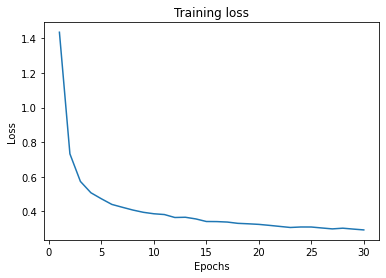

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,train_loss)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

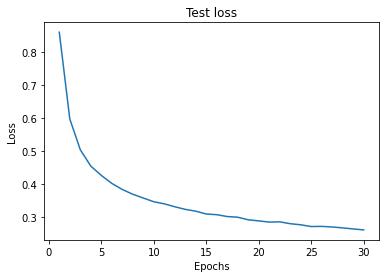

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,test_loss)
plt.title('Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

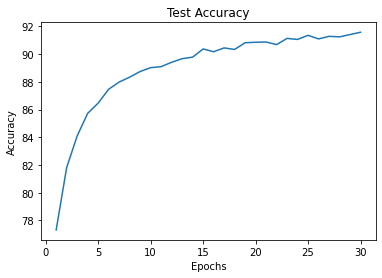

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,accuracy_test)
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
!cp AlexNetcategoriesmodel.pth '/content/drive/My Drive/Histopathology data/'